In [92]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import optax
import functools
from flax.training import train_state
from typing import Any, Dict
from functools import partial
import flax
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from tqdm import tqdm
from jax.nn.initializers import normal as normal_init

Array = Any
PRNGKey = jnp.ndarray


In [78]:
# Root directory for dataset
dataroot = "data/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

true_label = jnp.ones((batch_size, 1), dtype=jnp.int32)
false_label = jnp.zeros((batch_size, 1), dtype=jnp.int32)


In [240]:
class Decoder(nn.Module):
    @nn.compact
    def __call__(self, z, train: bool = True):
        z = z.reshape((batch_size, 1, 1, nz))
        x = nn.ConvTranspose(features=ngf * 8, kernel_size=(4, 4),
                             strides=(2, 2), padding='SAME', use_bias=False, kernel_init=normal_init(0.02))(z)
        x = nn.BatchNorm(
            use_running_average=not train, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=ngf * 4, kernel_size=[4, 4],
                             strides=[2, 2], padding='VALID', use_bias=False, kernel_init=normal_init(0.02))(x)
        x = nn.BatchNorm(
            use_running_average=not train, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=ngf * 2, kernel_size=[4, 4],
                             strides=[2, 2], padding='VALID', use_bias=False, kernel_init=normal_init(0.02))(x)
        x = nn.BatchNorm(
            use_running_average=not train, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=ngf, kernel_size=(
            4, 4), strides=(2, 2), padding='VALID', use_bias=False, kernel_init=normal_init(0.02))(x)
        x = nn.BatchNorm(
            use_running_average=not train, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=nc, kernel_size=[
            6, 6], strides=[2, 2], padding='VALID', use_bias=False, kernel_init=normal_init(0.02))(x)
        return jnp.tanh(x)


In [123]:
class Discriminator(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True):
        x = nn.Conv(features=ndf, kernel_size=[4, 4], strides=[
                    2, 2], padding='VALID', use_bias=True, kernel_init=normal_init(0.02))(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=ndf * 2, kernel_size=[4, 4],
                    strides=[2, 2], padding='VALID', use_bias=True, kernel_init=normal_init(0.02))(x)
        x = nn.BatchNorm(
            use_running_average=not train, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=ndf * 4, kernel_size=[4, 4],
                    strides=[2, 2], padding='VALID', use_bias=True, kernel_init=normal_init(0.02))(x)
        x = nn.BatchNorm(
            use_running_average=not train, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=ndf * 8, kernel_size=[4, 4],
                    strides=[2, 2], padding='VALID', use_bias=True, kernel_init=normal_init(0.02))(x)
        x = nn.BatchNorm(
            use_running_average=not train, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=1, kernel_size=[4, 4], strides=[
                    2, 2], padding='VALID', use_bias=True, kernel_init=normal_init(0.02))(x)
        x = jnp.reshape(x, [x.shape[0], -1])

        return x


In [142]:
class TrainState(train_state.TrainState):
    batch_stats: Any


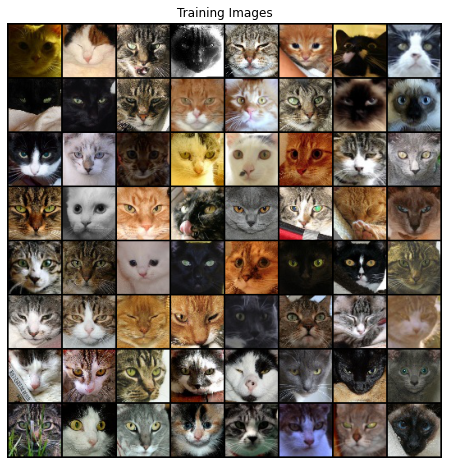

In [73]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (
    torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[
           :64], padding=2, normalize=True).cpu(), (1, 2, 0)))


In [143]:
@partial(jax.pmap, static_broadcasted_argnums=(1, 2))
def create_state(rng, model_cls, input_shape):
    r"""Create the training state given a model class. """

    model = model_cls()

    tx = optax.adam(lr, b1=beta1, b2=0.999)  # defining the optimizer
    variables = model.init(rng, jnp.ones(input_shape)
                           )   # initializing the model

    state = TrainState.create(apply_fn=model.apply, tx=tx,
                              params=variables['params'], batch_stats=variables['batch_stats'])

    return state


@jax.pmap
def sample_from_generator(generator_state, input_noise):
    """Sample from the generator in evaluation mode."""
    generated_data = generator_state.apply_fn(
        {'params': generator_state.params,
         'batch_stats': generator_state.batch_stats},
        input_noise, train=False, mutable=False)
    return generated_data


In [144]:
import optax


class TrainState(train_state.TrainState):
    batch_stats: Any


@partial(jax.pmap, axis_name='num_devices')
def generator_step(generator_state: TrainState,
                   discriminator_state: TrainState,
                   key: PRNGKey):
    r"""The generator is updated by generating data and letting the discriminator
    critique it. It's loss goes down if the discriminator wrongly predicts it to
    to be real data."""
    input_noise = jax.random.normal(
        key, (batch_size, nz))

    def loss_fn(params):
        generated_data, mutables = generator_state.apply_fn(
            {'params': params, 'batch_stats': generator_state.batch_stats},
            input_noise, mutable=['batch_stats'])

        logits, _ = discriminator_state.apply_fn(
            {'params': discriminator_state.params,
             'batch_stats': discriminator_state.batch_stats},
            generated_data, mutable=['batch_stats'])

        loss = -jnp.mean(jnp.log(nn.sigmoid(logits)))
        return loss, mutables

    # Generate data with the Generator, critique it with the Discriminator.
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, mutables), grads = grad_fn(generator_state.params)

    # Average across the devices.
    grads = jax.lax.pmean(grads, axis_name='num_devices')
    loss = jax.lax.pmean(loss, axis_name='num_devices')

    # Update the Generator through gradient descent.
    new_generator_state = generator_state.apply_gradients(
        grads=grads, batch_stats=mutables['batch_stats'])

    return new_generator_state, loss


@partial(jax.pmap, axis_name='num_devices')
def discriminator_step(generator_state: TrainState,
                       discriminator_state: TrainState,
                       real_data: jnp.ndarray,
                       key: PRNGKey):
    r"""The discriminator is updated by critiquing both real and generated data,
    It's loss goes down as it predicts correctly if images are real or generated.
    """
    input_noise = jax.random.normal(
        key, (batch_size, nz))

    generated_data, _ = generator_state.apply_fn(
        {'params': generator_state.params,
         'batch_stats': generator_state.batch_stats},
        input_noise, mutable=['batch_stats'])

    def loss_fn(params):
        logits_real, mutables = discriminator_state.apply_fn(
            {'params': params, 'batch_stats': discriminator_state.batch_stats},
            real_data, mutable=['batch_stats'])

        logits_generated, mutables = discriminator_state.apply_fn(
            {'params': params, 'batch_stats': mutables['batch_stats']},
            generated_data, mutable=['batch_stats'])

        real_loss = optax.sigmoid_binary_cross_entropy(
            logits_real, true_label).mean()
        generated_loss = optax.sigmoid_binary_cross_entropy(
            logits_generated, false_label).mean()

        loss = (real_loss + generated_loss) / 2

        return loss, mutables
        # Critique real and generated data with the Discriminator.
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, mutables), grads = grad_fn(discriminator_state.params)

    # Average cross the devices.
    grads = jax.lax.pmean(grads, axis_name='num_devices')
    loss = jax.lax.pmean(loss, axis_name='num_devices')
    # Update the discriminator through gradient descent.
    new_discriminator_state = discriminator_state.apply_gradients(
        grads=grads, batch_stats=mutables['batch_stats'])

    return new_discriminator_state, loss


In [134]:
dataloader_iterator = iter(dataloader)


In [173]:
from flax.training.common_utils import shard, shard_prng_key

key = jax.random.PRNGKey(seed=0)
key_generator, key_discriminator, key = jax.random.split(key, 3)
key_generator = shard_prng_key(key_generator)
key_discriminator = shard_prng_key(key_discriminator)

discriminator_state = create_state(key_discriminator, Discriminator,
                                   (batch_size, *jnp.moveaxis(jnp.array(next(dataloader_iterator)[0].cpu().detach().numpy()), 1, 3).shape))
generator_state = create_state(key_generator, Decoder,
                               (batch_size, nz))

generator_input = jax.random.normal(
    key, (batch_size, nz))  # random noise
generator_input = shard(generator_input)

sample = sample_from_generator(generator_state, generator_input)
sample.shape


(1, 128, 38, 38, 3)

In [254]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

loss = {'generator': [], 'discriminator': []}

for epoch in tqdm(range(1, num_epochs + 1), desc="Epoch...",
                  position=0, leave=True):
    dataloader_iterator = iter(dataloader)
    with tqdm(total=len(dataloader), desc="Training...",
              leave=False) as progress_bar_train:
        for batch in range(len(dataloader)):
            key, key_generator, key_discriminator = jax.random.split(key, 3)
            key_generator = shard_prng_key(key_generator)
            key_discriminator = shard_prng_key(key_discriminator)

            batch = next(dataloader_iterator)[0]
            batch = jnp.moveaxis(jnp.array(batch.cpu().detach().numpy()), 1, 3)
            batch_data = shard(batch)
            generator_state, generator_loss = generator_step(generator_state,
                                                             discriminator_state, key_generator)
            discriminator_state, discriminator_loss = discriminator_step(
                generator_state, discriminator_state, batch_data, key_discriminator)
            progress_bar_train.update(1)

        metrics = jax.device_get([generator_loss[0], discriminator_loss[1]])

        message = f"Epoch: {epoch: <2} | "
        message += f"Generator loss: {metrics[0]:.3f} | "
        message += f"Discriminator loss: {metrics[1]:.3f}"
        progress_bar_train.write(message)

    sample = sample_from_generator(generator_state, generator_input)
    sample = sample.reshape((-1, 64, 64, 3))

    # Next, plot the static samples, save the fig to disk.
    if epoch % 1 == 0:
        fig, axes = plt.subplots(nrows=11, ncols=11, figsize=(11, 11))
        for ax, image in zip(sum(axes.tolist(), []), sample):
            ax.imshow(image)
            ax.set_axis_off()
        plt.show()
        fig.savefig(f"results/1_GAN/GAN_epoch_{epoch}.png")
        plt.close(fig)


Epoch...:   0%|          | 0/5 [00:00<?, ?it/s]

Training...:   0%|          | 0/124 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [148]:
next(dataloader_iterator)[0].shape


torch.Size([128, 3, 64, 64])

In [246]:
sample = sample_from_generator(generator_state, generator_input)
sample = sample.reshape((-1, 64, 64, 3))


In [248]:
sample.min()


DeviceArray(-0.06026315, dtype=float32)

In [249]:
sample.max()


DeviceArray(0.07508727, dtype=float32)